In [1]:
import pydpmd as dp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import numpy as np
import h5py
from tqdm import tqdm
from pydpmd.plot import draw_particles_frame, draw_circle
from system_building_resources import *
from correlation_functions import compute_rotational_isf, compute_rotational_msd

def get_relaxation_time(f, t, max_t=None):
    if max_t is None:
        max_t = max(t)
    mask = t <= max_t
    tau = np.interp(1 / np.e, f[mask][::-1], t[mask][::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def msd_fit(x, y):
    m = x > np.max(x) / 50
    x = np.log10(x[m])
    y = np.log10(y[m])

    from scipy.optimize import curve_fit
    def f(x, b):
        return x + b
    b, err = curve_fit(f, x, y)

    return 10 ** b[0], err[0][0]

In [2]:
dynamics_root = '/home/mmccraw/dev/data/11-06-25/dynamics-loop'

results = {
    'nv': [],
    'mu': [],
    'isf': [],
    'msd': [],
    'rot_msd': [],
    'tau': [],
    'delta_phi': [],
    'phi': [],
    'tau_isf': [],
    'D': [],
    'err': [],
    'D_rot': [],
    'rot_err': [],
}

for fname in os.listdir(dynamics_root):
    path = os.path.join(dynamics_root, fname)
    try:
        if not (os.path.exists(os.path.join(path, 'isf.npz')) and os.path.exists(os.path.join(path, 'msd.npz'))):
            data = dp.data.load(path, location=['final', 'init'], load_trajectory=True)
        else:
            data = dp.data.load(path, location=['final', 'init'])
        data.calculate_mu_eff()
    except:
        continue
    isf, tau = compute_rotational_isf(data, os.path.join(path, 'isf.npz'))
    msd, tau = compute_rotational_msd(data, os.path.join(path, 'msd.npz'))

    results['nv'].extend(data.n_vertices_per_particle[data.system_offset[:-1]])
    results['mu'].extend(data.mu_eff[data.system_offset[:-1]])
    results['isf'].extend(isf.T)
    results['msd'].extend(msd[..., 0].T)
    results['rot_msd'].extend(msd[..., 1].T)
    results['tau'].extend([tau for _ in range(isf.shape[1])])
    results['phi'].extend(data.packing_fraction)
    results['delta_phi'].extend(data.delta_phi)

    for _isf in isf.T:
        results['tau_isf'].append(get_relaxation_time(_isf / _isf[0], tau, np.max(tau) / 10))
    for _msd in msd[..., 0].T:
        D, err = msd_fit(tau, _msd)
        results['D'].append(D)
        results['err'].append(err)
    for _msd in msd[..., 1].T:
        D, err = msd_fit(tau, _msd)
        results['D_rot'].append(D)
        results['rot_err'].append(err)


results = pd.DataFrame(results)


In [ ]:
for fname in os.listdir(dynamics_root):
    fname = 'run_1'
    path = os.path.join(dynamics_root, fname)
    data = dp.data.load(path, location=['final', 'init'], load_trajectory=True)
    data.calculate_mu_eff()
    break


Loading trajectory: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


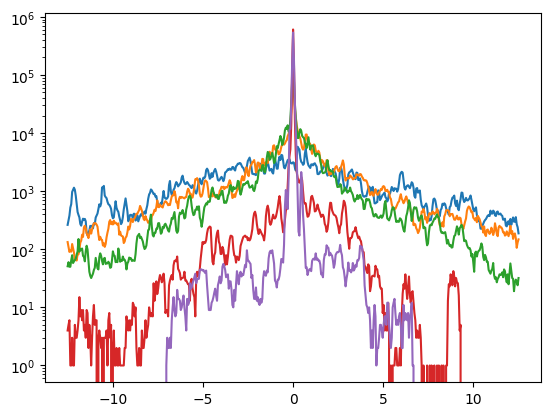

In [75]:
p = data.trajectory.pos.copy()
t = data.trajectory.angle.copy()
u = p - np.mean(p, axis=0)
ut = t - np.mean(t, axis=0)

for sid in [0, 1, 2, 3, 4]:
    beg = data.system_offset[sid]
    end = data.system_offset[sid+1]

    n_bins = 500
    bins = np.linspace(-0.5, 0.5, n_bins)
    t_bins = 4 * np.linspace(-np.pi, np.pi, n_bins)

    dx = np.histogram(u[:, beg:end][..., 0].flatten(), bins=bins)[0]
    dy = np.histogram(u[:, beg:end][..., 1].flatten(), bins=bins)[0]
    dt = np.histogram(ut[:, beg:end].flatten(), bins=t_bins)[0]

    x = (bins[:-1] + bins[1:]) / 2
    theta = (t_bins[:-1] + t_bins[1:]) / 2

    # plt.plot(x, dx, label='x')
    # plt.plot(x, dy, label='y')
    plt.plot(theta, dt, label='t')
# plt.legend()
plt.yscale('log')
plt.show()


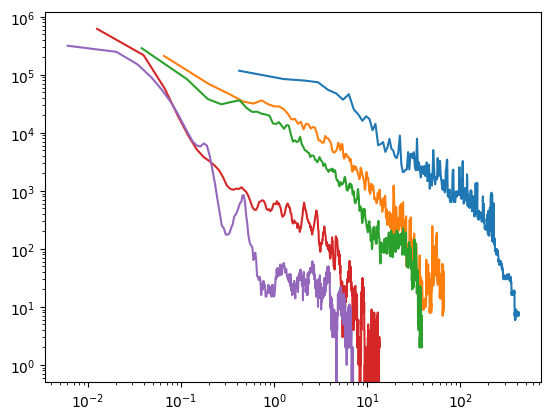

In [ ]:
t = data.trajectory.angle.copy()
ut = t - np.mean(t, axis=0)

for sid in [0, 1, 2, 3, 4]:
    beg = data.system_offset[sid]
    end = data.system_offset[sid+1]

    dt = np.abs(ut[:, beg:end].flatten())

    n_bins = 500
    t_bins = np.linspace(-1e-2, np.max(dt), n_bins)

    dt = np.histogram(dt, bins=t_bins)[0]

    theta = (t_bins[:-1] + t_bins[1:]) / 2

    plt.plot(theta, dt)
plt.yscale('log')
plt.xscale('log')
plt.show()


In [62]:
nv = data.n_vertices_per_particle[data.system_offset[:-1]].copy()
mu = data.mu_eff[data.system_offset[:-1]].copy()

mu[nv == 6]

np.argwhere(nv == 6)

array([[0],
       [1],
       [2],
       [3],
       [4]])

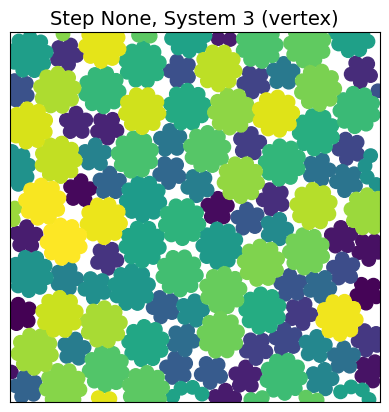

In [65]:
draw_particles_frame(None, plt.gca(), data, 3, True, 'vertex', 'viridis', None)
# 19

In [3]:
root = '/home/mmccraw/dev/data/11-06-25/cv-loop'

df = {
    'nv': [],
    'mu': [],
    'cv': [],
    'phi': [],
    'delta_phi': []
}

for fname in tqdm(os.listdir(root)):

    data = dp.data.load(os.path.join(root, fname), location=['final', 'init'], load_trajectory=True)
    data.calculate_mu_eff()

    N = data.system_size - 1
    d = 3
    N_dof = d * N
    temp = 2 * np.mean(data.trajectory.ke_total, axis=0) / N_dof
    TE = np.mean(data.trajectory.pe_total + data.trajectory.ke_total, axis=0)

    mu = data.mu_eff[data.system_offset[:-1]]
    nv = data.n_vertices_per_particle[data.system_offset[:-1]]

    for nv_mu in np.unique(np.column_stack((nv, mu)), axis=0):
        mask = (nv == nv_mu[0]) & (mu == nv_mu[1])
        C_v, _ = np.polyfit(temp[mask], TE[mask], 1)

        df['nv'].append(nv_mu[0])
        df['mu'].append(nv_mu[1])
        df['cv'].append(C_v / N[mask][0])
        df['phi'].append(data.packing_fraction[mask][0])
        df['delta_phi'].append(data.delta_phi[mask][0])

df = pd.DataFrame(df)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


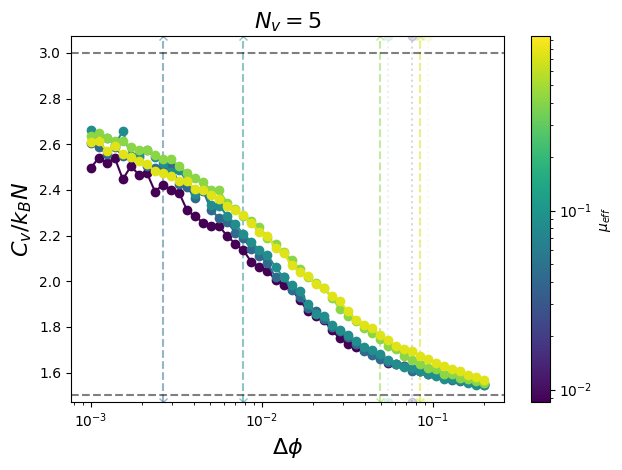

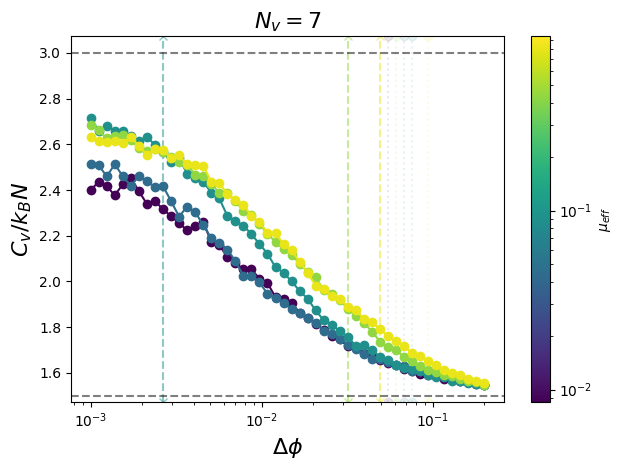

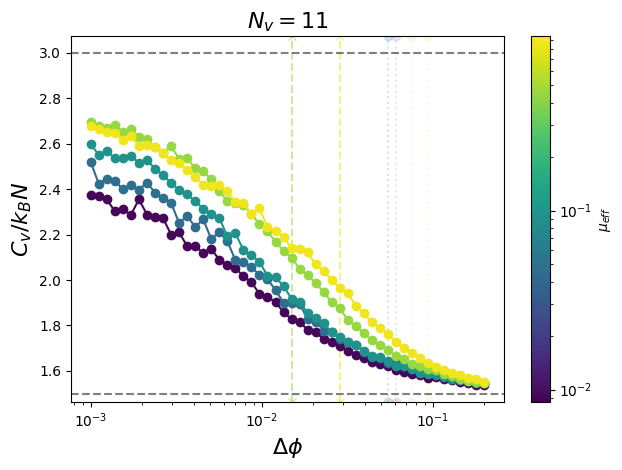

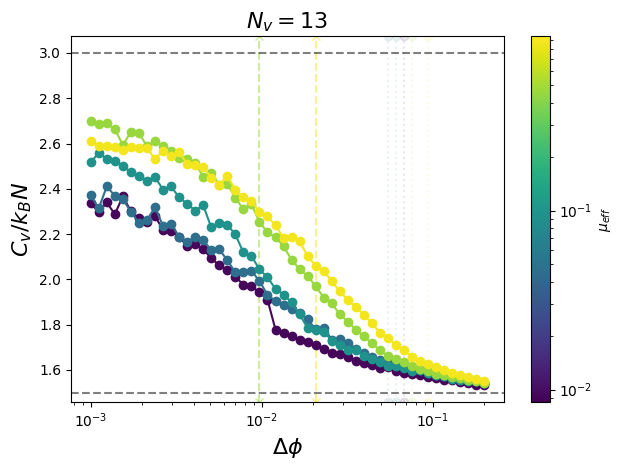

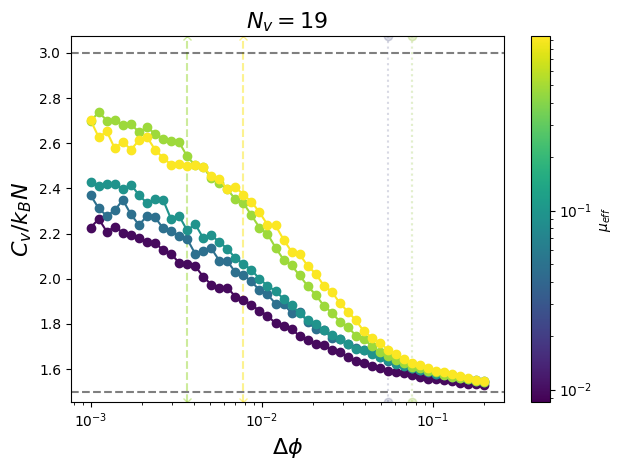

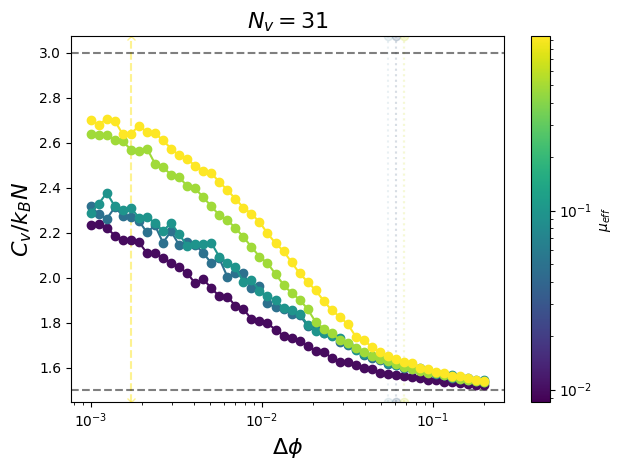

In [8]:
mu_norm = LogNorm(vmin=np.min(df.mu), vmax=np.max(df.mu))
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        mask = (df.nv == nv) & (df.mu == mu)
        _df = df[mask]
        delta_phi = _df.delta_phi.values
        cv = _df.cv.values
        cv = cv[np.argsort(delta_phi)]
        delta_phi = delta_phi[np.argsort(delta_phi)]
        plt.plot(delta_phi, cv, c=cmap(mu_norm(mu)), marker='o')

        _df = results[(results.nv == nv) & (results.mu == mu)].copy()
        _df = _df.iloc[_df.delta_phi.argsort().values]
        
        m = (_df.phi > _df.phi[_df.err > 5e-3].min()).values
        D = _df.D.values
        D[m] = np.nan

        m = (_df.phi > _df.phi[_df.rot_err > 5e-3].min()).values
        D_rot = _df.D_rot.values
        D_rot[m] = np.nan

        plt.axvline(np.min(_df.delta_phi[~np.isnan(_df.D)]), c=cmap(mu_norm(mu)), linestyle=':', alpha=0.1, zorder=0, marker='o')

        tau_c = 1e3
        if np.any(_df.tau_isf > tau_c):
            plt.axvline(_df[_df.tau_isf > tau_c].delta_phi.max(), c=cmap(mu_norm(mu)), linestyle='--', alpha=0.5, zorder=0, marker='x')

    plt.xscale('log')
    plt.axhline(d, color='k', alpha=0.5, linestyle='--', zorder=0)
    plt.axhline(d / 2, color='k', alpha=0.5, linestyle='--', zorder=0)

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.abs(df.mu))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.xlabel(r'$\Delta \phi$', fontsize=16)
    plt.ylabel(r'$C_v / k_B N$', fontsize=16)

    plt.title(fr'$N_v=${int(nv)-1}', fontsize=16)

    plt.tight_layout()
    # plt.savefig(f'cv-figures/NV-{nv}.png', dpi=600)

    plt.show()

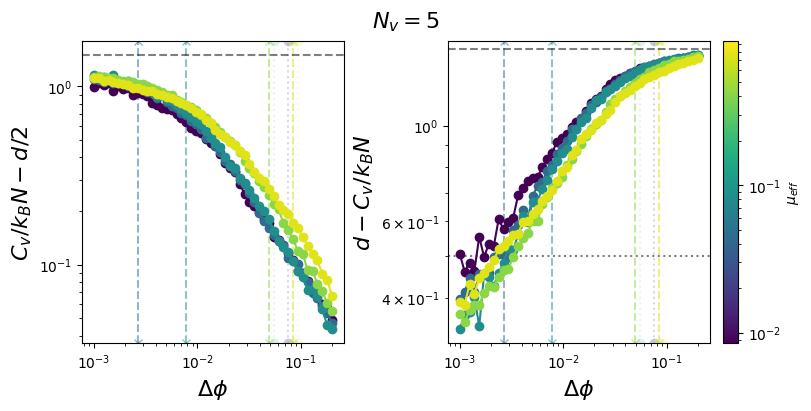

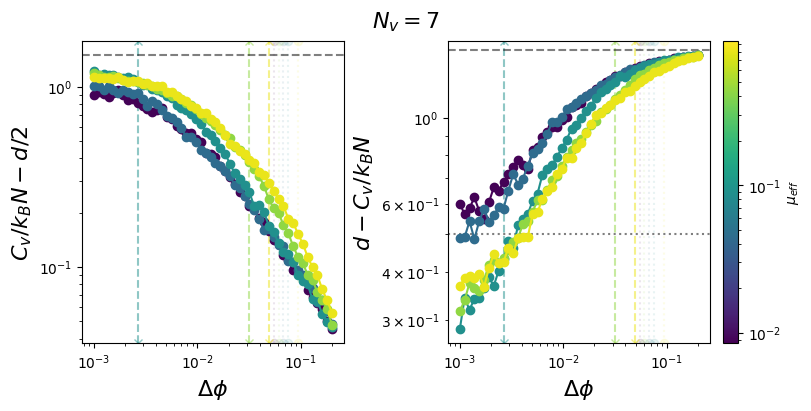

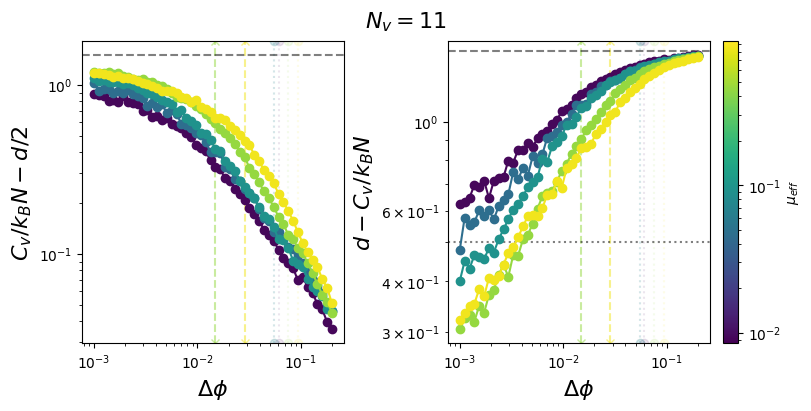

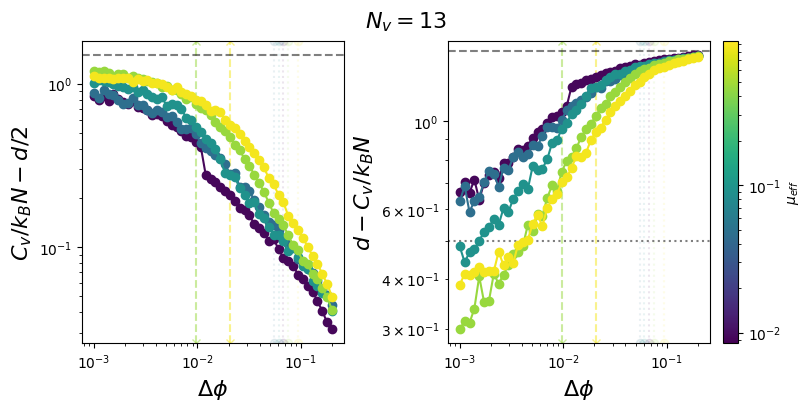

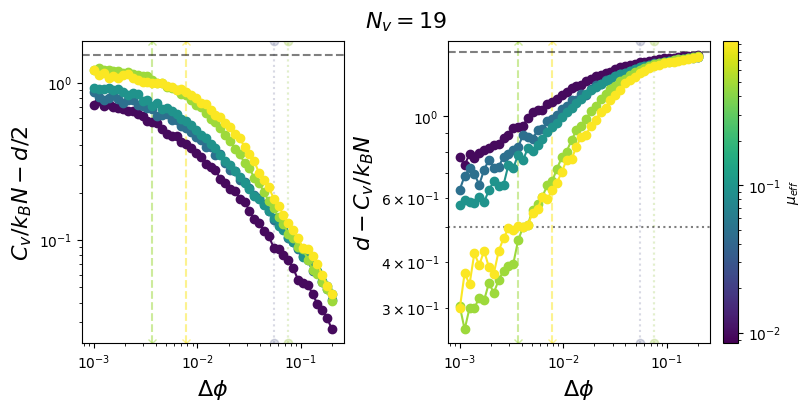

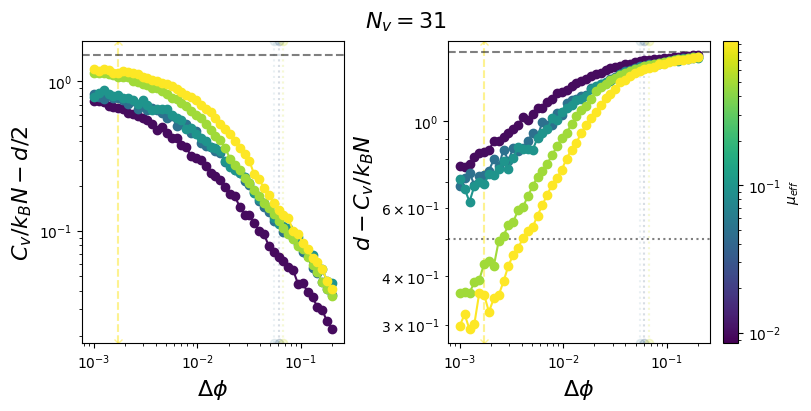

In [23]:
mu_norm = LogNorm(vmin=np.min(df.mu), vmax=np.max(df.mu))
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    fig, ax = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
    for mu in np.unique(df.mu[df.nv == nv]):
        mask = (df.nv == nv) & (df.mu == mu)
        _df = df[mask]
        delta_phi = _df.delta_phi.values
        cv = _df.cv.values
        cv = cv[np.argsort(delta_phi)]
        delta_phi = delta_phi[np.argsort(delta_phi)]
        ax[0].plot(delta_phi, cv-1.5, c=cmap(mu_norm(mu)), marker='o')
        ax[1].plot(delta_phi, 3-cv, c=cmap(mu_norm(mu)), marker='o')

        _df = results[(results.nv == nv) & (results.mu == mu)].copy()
        _df = _df.iloc[_df.delta_phi.argsort().values]
        
        m = (_df.phi > _df.phi[_df.err > 5e-3].min()).values
        D = _df.D.values
        D[m] = np.nan

        m = (_df.phi > _df.phi[_df.rot_err > 5e-3].min()).values
        D_rot = _df.D_rot.values
        D_rot[m] = np.nan

        for a in ax:
            a.axvline(np.min(_df.delta_phi[~np.isnan(_df.D)]), c=cmap(mu_norm(mu)), linestyle=':', alpha=0.1, zorder=0, marker='o')
            tau_c = 1e3
            if np.any(_df.tau_isf > tau_c):
                a.axvline(_df[_df.tau_isf > tau_c].delta_phi.max(), c=cmap(mu_norm(mu)), linestyle='--', alpha=0.5, zorder=0, marker='x')

    for a in ax:
        a.set_yscale('log')
        a.set_xscale('log')
        a.set_xlabel(r'$\Delta \phi$', fontsize=16)
    ax[0].axhline(d / 2, color='k', alpha=0.5, linestyle='--', zorder=0)
    ax[1].axhline(d / 2, color='k', alpha=0.5, linestyle='--', zorder=0)
    ax[1].axhline(1/2, color='k', alpha=0.5, linestyle=':', zorder=0)

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.abs(df.mu))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    ax[0].set_ylabel(r'$C_v / k_B N - d/2$', fontsize=16)
    ax[1].set_ylabel(r'$d-C_v / k_B N$', fontsize=16)

    plt.suptitle(fr'$N_v=${int(nv)-1}', fontsize=16)

    plt.savefig(f'cv-figures-offset/NV-{nv}.png', dpi=600)

    plt.show()

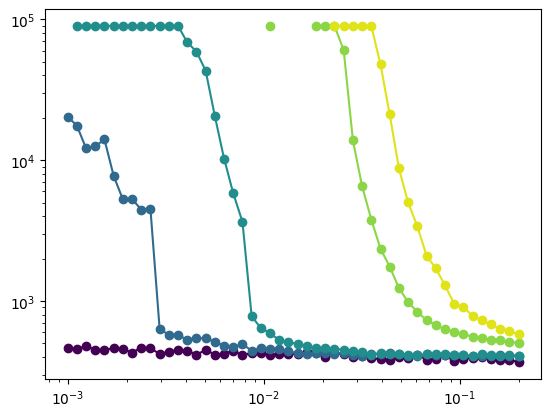

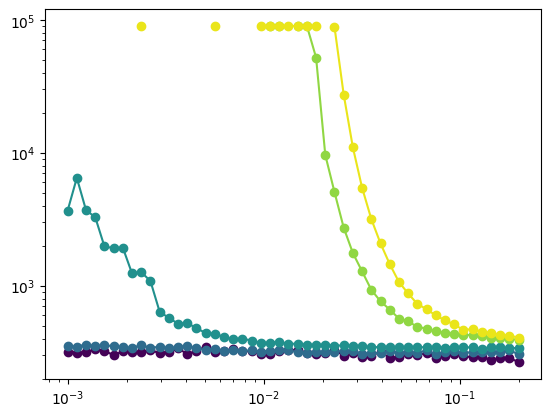

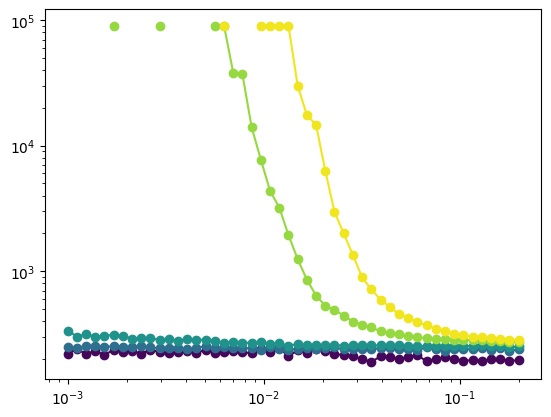

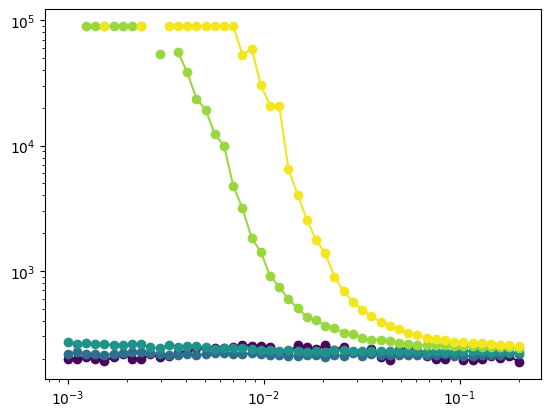

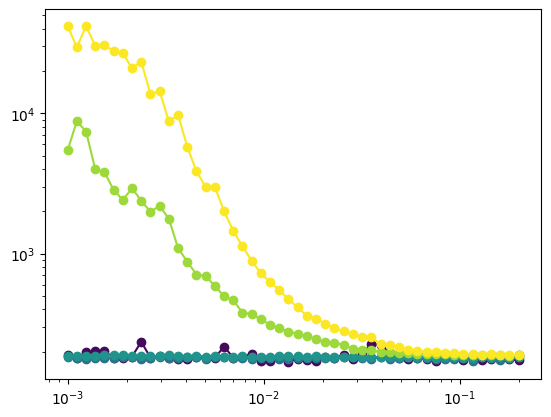

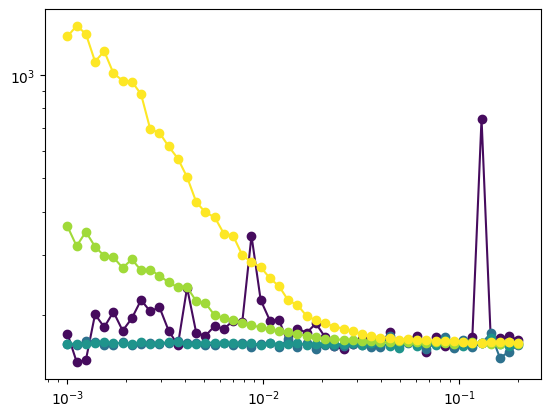

In [182]:
for nv in np.unique(results.nv):
    for mu in np.unique(results[results.nv == nv].mu):
        mask = (results.nv == nv) & (results.mu == mu)
        _df = results[mask].copy()
        _df = _df.iloc[_df.delta_phi.argsort().values]
        
        plt.plot(_df.delta_phi, _df.tau_isf, marker='o', c=cmap(mu_norm(mu)))
        
        m = (_df.phi > _df.phi[_df.err > 5e-3].min()).values
        D = _df.D.values
        D[m] = np.nan
        # plt.plot(_df.delta_phi, D, marker='o', c=cmap(mu_norm(mu)))

        m = (_df.phi > _df.phi[_df.rot_err > 5e-3].min()).values
        D_rot = _df.D_rot.values
        D_rot[m] = np.nan
        # plt.plot(_df.delta_phi, D_rot, marker='o', c=cmap(mu_norm(mu)))
        # plt.plot(_df.delta_phi, _df.rot_err, marker='o', c=cmap(mu_norm(mu)))
        

    plt.yscale('log')
    plt.xscale('log')
    plt.show()


In [127]:
D

array([0.00070236])

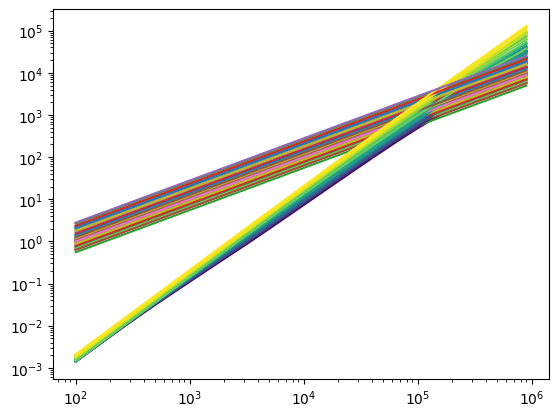

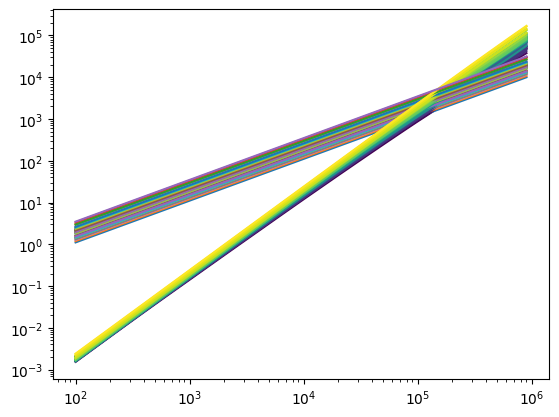

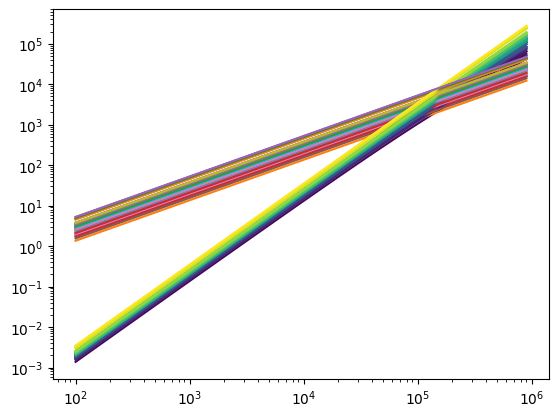

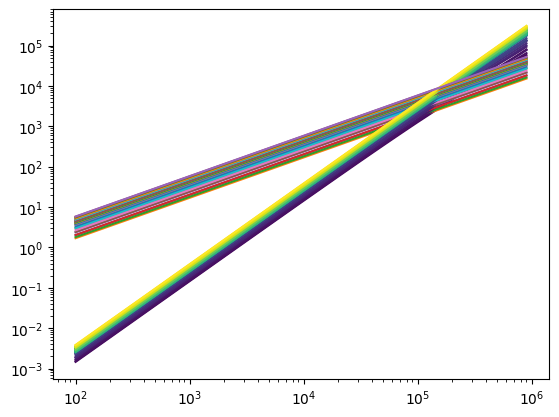

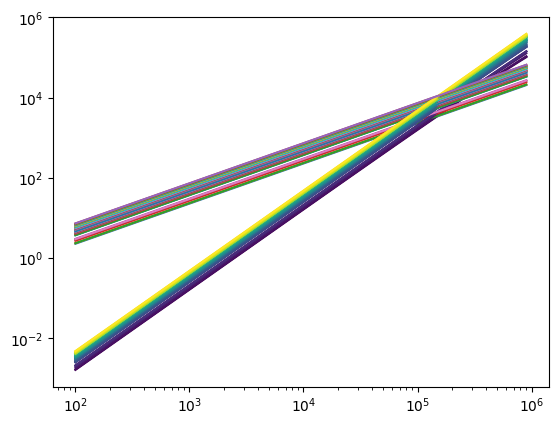

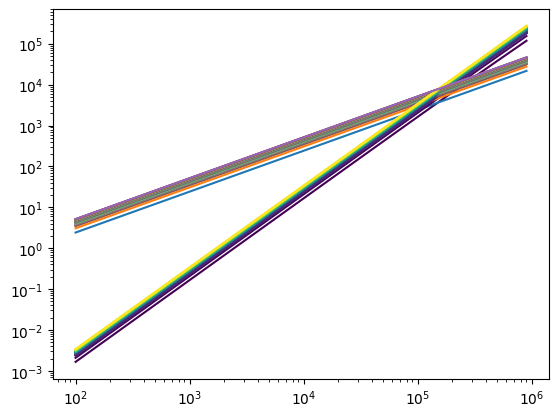

In [161]:
delta_phi_norm = LogNorm(vmin=results.delta_phi.min(), vmax=results.delta_phi.max())
cmap = plt.cm.viridis

for nv in np.unique(results.nv):
    for mu in np.unique(results[results.nv == nv].mu):
        mask = (results.nv == nv) & (results.mu == mu)
        _df = results[mask].copy()
        _df = _df.iloc[_df.delta_phi.argsort().values]
        for i, row in _df.iterrows():
            plt.plot(row.tau, row.rot_msd, c=cmap(delta_phi_norm(row.delta_phi)))
            D, err = msd_fit(row.tau, row.rot_msd)
            plt.plot(row.tau, D * row.tau)
            # print(err)
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
        break
    # break

